BSD 3-Clause License

Copyright (c) 2025, Pranjal Choudhury

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.


## import the dependencies

In [1]:
from scipy.fftpack import fft2, fftshift
import math
import matplotlib.pyplot as plt
import numpy as np
from zernike_generator import zernikegenerator
import tifffile
import os
from tqdm import tqdm

## set up the aberrations in terms of zernike modes

In [2]:
zernike_modes = zernikegenerator(15, 450)

In [3]:
zernike_modes.shape

(136, 450, 450)

## set up the simulaion parameters regarding the grating array

In [4]:
SLM_display_dim = np.zeros([450, 450])
input_n_element = 5
rms_amplitude = 0.5
single_holo_dim = int(len(SLM_display_dim)/input_n_element)
initial_frequency_x = 15
initial_frequency_y = 15
increment_xy = 6
topological_charge = 0

In [5]:
rows = np.arange(-1, 1, 2 / (single_holo_dim))
column = np.arange(-1, 1, 2 / (single_holo_dim))
Rows, Columns = np.meshgrid(rows, column)
z_tan = np.arctan2(Columns, Rows)


## make the grating array 

In [6]:
for m in range(input_n_element):
    for n in range(input_n_element):
        x_frequency = initial_frequency_x + m * increment_xy
        y_frequency = initial_frequency_y + n * increment_xy
        hologram = np.cos(math.pi * (Rows * x_frequency +
                                     Columns * y_frequency) +
                          topological_charge * z_tan)  # Interference of two waves
        circle = np.sqrt(Rows ** 2 + Columns ** 2) < 1
        circ_hologram = np.multiply(hologram, circle) > 0
        SLM_display_dim[m * (single_holo_dim): (m + 1) * (single_holo_dim ),
        n * (single_holo_dim ): (n + 1) * (single_holo_dim )] = circ_hologram



## Hologram dispay

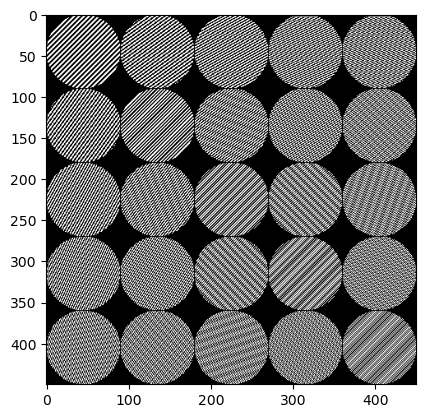

In [ ]:

plt.figure()
plt.imshow(SLM_display_dim, cmap='gray')
plt.show()

## disaplay the focal spot array for a plane wavefront

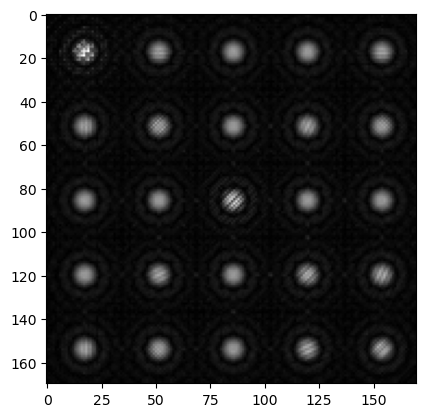

In [8]:
fourier_plane = fftshift(fft2(SLM_display_dim,[512, 512]))
abs_fourier_plane = np.abs(fourier_plane)
focal_spots_reference = abs_fourier_plane[324:494,324:494]

plt.figure()
plt.imshow(focal_spots_reference, cmap='gray')

plt.show()

In [9]:
os.makedirs('datasets',exist_ok=True)


In [10]:
tifffile.imwrite('datasets/reference.tif', focal_spots_reference)

## display focal spos for aberrated beam

In [ ]:

# Add aberration in the holograms
aberration =  0.6*zernike_modes[5] + 0.2*zernike_modes[8] + 0.3*zernike_modes[10]

Add_aberration = SLM_display_dim * np.exp(1j*( aberration))
aberrated_focal_spots = fftshift(fft2(Add_aberration,[512,512]))
abs_aberrated_focal_spots = np.abs(aberrated_focal_spots)
focal_spots = abs_aberrated_focal_spots[320:500,320:500]

plt.figure()
plt.imshow(focal_spots , cmap='gray')
tifffile.imwrite('datasets/test_data.tif', focal_spots)
plt.show()

## make training dataset

In [16]:


poisson_scale_factor = 100
gaussian_noise_std = 5

number_of_data = 50
number_of_zernike_modes = 36
spots_array = np.zeros((number_of_data, 180, 180), dtype='float32')
# aberration_strengths = np.random.uniform(-0.5, 0.5, (number_of_data, number_of_zernike_modes))  # Generate all random numbers at once
# aberrations = [zernike_modes[i+3] for i in range(number_of_zernike_modes)]

aberration_strengths = np.zeros((number_of_data, number_of_zernike_modes))
# Define aberration ranges for different Zernike modes
for i in range(number_of_data):
    aberration_strengths[i, 0:12] = np.random.uniform(-1., 1., 12)
    aberration_strengths[i, 12:36] =  np.random.uniform(-0.1, 0.1, 24)
    # aberration_strengths[i, 32:] = np.zeros(88) # np.random.uniform(-0.05, 0.05, 88)

aberrations = [zernike_modes[i+3] for i in range(number_of_zernike_modes)] 


# Precompute the crop indices for slicing, so they aren't repeated in the loop
crop_x_start, crop_x_end = 320, 500
crop_y_start, crop_y_end = 320, 500

for i in tqdm(range(number_of_data)):
# Compute the weighted sum of the 15 aberration images for this data point
    aberration = np.sum(aberration_strengths[i, :, np.newaxis, np.newaxis] * np.array(aberrations), axis=0)
    # Calculate aberrated focal spots with FFT
    Add_aberration = SLM_display_dim * np.exp(1j * aberration)
    aberrated_focal_spots = fftshift(fft2(Add_aberration, [512,512]))
    
    # Get the absolute value and crop directly into the array slice
    spots = np.random.poisson(np.abs(aberrated_focal_spots)[crop_x_start:crop_x_end, crop_y_start:crop_y_end]) 
    
    # Add Poisson noise
    focal_spots_poisson = np.random.poisson(spots * poisson_scale_factor) / poisson_scale_factor

    # Add Gaussian noise
    focal_spots_noisy = focal_spots_poisson + np.random.normal(0, gaussian_noise_std, focal_spots_poisson.shape)
    
    # Save the noisy image to spots_array
    spots_array[i] = focal_spots_noisy.astype('float32')



100%|██████████| 50/50 [00:03<00:00, 14.66it/s]


aberration strengths are :[-0.44823435  0.96204334 -0.13946634  0.77217649  0.48504421 -0.84456024
 -0.79517095  0.35011143 -0.35386831 -0.32759548 -0.4303159   0.85969926
 -0.04140483 -0.07811938 -0.03984511  0.03248069  0.00480507 -0.00223364
 -0.08950059 -0.03675828  0.01885112  0.03061538 -0.01624941 -0.00744334
 -0.04089198 -0.0895017   0.07283733 -0.07790039  0.03117749 -0.00907707
  0.02067125  0.02777835 -0.04379177  0.07744916  0.06364443  0.06830939]


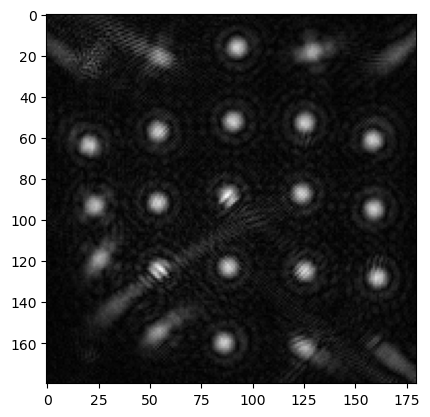

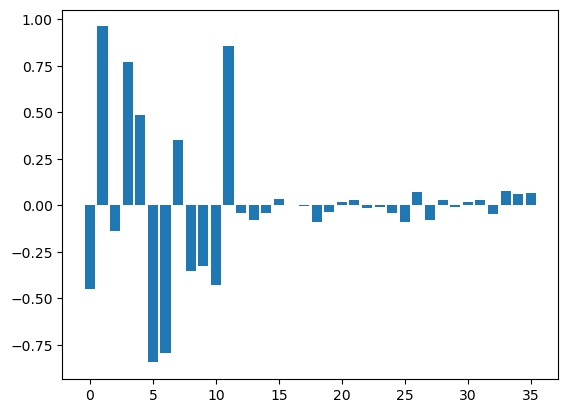

In [14]:
number = 1
plt.figure()
plt.imshow(spots_array[number], cmap='gray')
plt.figure()
plt.bar(np.arange(aberration_strengths.shape[1]), aberration_strengths[number])
print(f'aberration strengths are :{aberration_strengths[number]}')
plt.show()

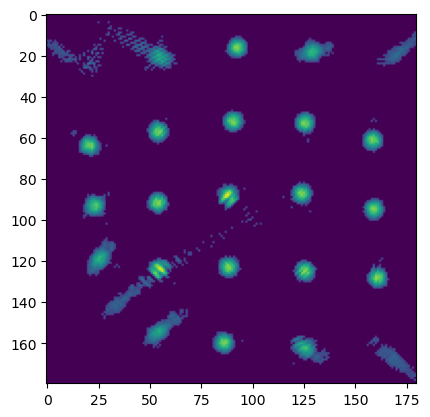

In [15]:
plt.imshow(np.where(spots_array[number]>0.2*np.max(spots_array[number]),spots_array[number],0))

In [58]:
tifffile.imwrite('datasets/testing_50.tif', spots_array)
np.save('datasets/testing_50.npy', aberration_strengths)

## test data generation

In [16]:
poisson_scale_factor = 100
gaussian_noise_std = 5

spots_array = np.zeros((12, 180,180), dtype='float32')
aberration_strengths = []
for i in range(12):
    # Add aberration in the holograms
    # for j in range(15):
    aberration = 0.5 * zernike_modes[i+3]

    Add_aberration = SLM_display_dim * np.exp(1j*( aberration))
    aberrated_focal_spots = fftshift(fft2(Add_aberration,[512,512]))
    abs_aberrated_focal_spots = np.abs(aberrated_focal_spots)
    focal_spots = abs_aberrated_focal_spots[320:500,320:500]
    
    # Add Poisson noise
    focal_spots_poisson = np.random.poisson(focal_spots * poisson_scale_factor) / poisson_scale_factor
    # Add Gaussian noise
    focal_spots_noisy = focal_spots_poisson + np.random.normal(0, gaussian_noise_std, focal_spots_poisson.shape)
    spots_array[i] = focal_spots_noisy.astype('float32')

In [17]:
tifffile.imwrite('datasets/test_z4_z15_0.5.tif', spots_array)
np.save('datasets/test_z4_z15_0.5.npy', 0.5*np.identity(12))

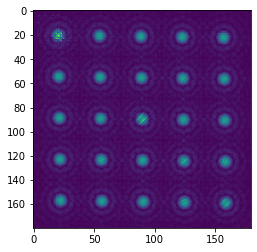

In [18]:
plt.imshow(spots_array[0])